# Lab 1
Tiffany Cappellari

3031798875

In [ ]:
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.colors as colors
import pandas as pd
import corner
import astropy.io.votable as votable
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord
from astroquery.utils.tap.core import TapPlus
import matplotlib.lines as lines
import scipy.stats as stats
import pymc3 as pm

import dustmaps.sfd
dustmaps.sfd.fetch()
from dustmaps.sfd import SFDQuery

%matplotlib inline

In [6]:
gaia = TapPlus(url = "https://gea.esac.esa.int/tap-server/tap")

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## 1. Top 100 RR Lyrae

In [44]:
job = gaia.launch_job_async('''\
SELECT TOP 100 *
FROM gaiadr2.vari_rrlyrae
WHERE pf IS NOT NULL
    AND num_clean_epochs_g > 40
''')

results = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


## 2. Raw Light Curves

In [45]:
# def get_data(source_id):
#     url = ('https://geadata.esac.esa.int/data-server/data?ID=Gaia+DR2+{}'
#            '&RETRIEVAL_TYPE=EPOCH_PHOTOMETRY&format=csv&band=G').format(source_id)
#     dat = pd.read_csv(url)
#     dat = dat[dat['band'] == 'G']
#     dat = dat[~dat['rejected_by_photometry']]
#     dat = dat[~dat['rejected_by_variability']]    
#     return dat

def get_data(sid):
    path = 'lcs/EPOCH_PHOTOMETRY-Gaia DR2 {}.xml'.format(sid)
    dat = votable.parse(path).get_first_table().to_table().to_pandas()
    dat = dat[dat['band'] == b'G']
    dat = dat[~dat['rejected_by_photometry']]
    dat = dat[~dat['rejected_by_variability']]  
    return dat

def get_all_data(rows):
    out = {}
    for i, row in enumerate(rows):
        sid = row['source_id']
        out[sid] = get_data(sid)
    return out

def plot_tm(source_id, mod, dat):
    plt.figure(figsize = (12, 8), facecolor = 'w')
    #mod = 0.9576506522842548
    #mod = 1 / 1.0442442442442443
    x = 'time'
    y = 'mag'
    plt.errorbar(dat[x] % mod, dat[y], yerr = 1.09 / dat['flux_over_error'], fmt = '.')
    #plt.scatter(dat[x] % mod, dat[y], linewidth = 1)
    plt.xlabel('{} % {}'.format(x, mod))
    plt.ylabel(y)
    plt.title('Time vs Magnitude for source_id={}'.format(source_id))
    plt.grid()
    plt.show()
    
chosen = results[3]
source_id = chosen['source_id']
dat = get_data(source_id)
plot_tm(source_id, chosen['pf'], dat)

FileNotFoundError: [Errno 2] No such file or directory: 'lcs/EPOCH_PHOTOMETRY-Gaia DR2 5816755332315333888.xml'

## 3. Lomb-Scargle Periodicity Diagram

In [ ]:
freq = np.linspace(0.8, 1.5, num = 1000)
power = LombScargle(dat['time'], dat['mag'], 1.09 / dat['flux_over_error']).power(freq)

plt.figure(figsize = (10, 6), facecolor = 'w')
plt.plot(freq, power)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid()
plt.show()

period = freq[np.argmax(power)]
print('Best freq: {}, Period: {}, Gaia: {}'.format(period, (1/period), chosen['pf']))

In [ ]:
all_dat = []
for i, chosen in enumerate(results):
    source_id = chosen['source_id']
    all_dat.append(get_data(source_id))
    print('{:.6}%'.format(100 * (i + 1) / len(results)), end = '\r')
print()

In [ ]:
# Compute g-band magnitude
all_mags = []
for dat in all_dat:
    all_mags.append(np.log(np.exp(dat['mag']).mean()))

## 4. Comparison to $\verb=vari_rrlyrae=$ catalog values

In [ ]:
all_freqs = []
freq = np.linspace(1.0, 2.5, num = 10000)
for dat, chosen in zip(all_dat, results):
    power = LombScargle(dat['time'], dat['mag'], 1.09 / dat['flux_over_error']).power(freq)
    all_freqs.append(freq[np.argmax(power)])

In [ ]:
plt.figure(figsize = (7, 6), facecolor = 'w')
plt.title('Gaia Freq vs. L-S Derived Freq (1/days)')
plt.scatter(all_freqs, 1 / results['pf'])
plt.ylabel('Gaia Freq')
plt.xlabel('L-S Derived Freq')
plt.show()

The results are very close to Gaia's PF column. Only a few (4) stars are off.

## 5. Fourier Transform

$$f(t) = A_0 + \sum\limits_{k=1}^{K}\left( a_k\sin(k\omega t) + b_k\cos(k\omega t) \right)$$
$$\underbrace{ 
\begin{bmatrix} 
    f(t_1) \\ 
    f(t_2) \\ 
    \vdots \\ 
    f(t_n) 
\end{bmatrix} }_{y} = 
\begin{bmatrix} 
    \sin\left(1\omega t_1\right) & \sin\left(2\omega t_1\right) & \cdots & \sin\left(K\omega t_1\right) \\ 
    \sin\left(1\omega t_2\right) & \sin\left(2\omega t_2\right) & \cdots & \sin\left(K\omega t_2\right) \\ 
    \vdots & \vdots & \ddots & \vdots \\ \sin\left(1\omega t_n\right) & \sin\left(2\omega t_n\right) & \cdots & \sin\left(K\omega t_n\right) 
\end{bmatrix} 
\begin{bmatrix} 
    a_1 \\ 
    a_2 \\ 
    a_3 \\ 
    \vdots \\ 
    a_K 
\end{bmatrix} + 
\begin{bmatrix} 
    \cos\left(1\omega t_1\right) & \cos\left(2\omega t_1\right) & \cdots & \cos\left(K\omega t_1\right) \\ 
    \cos\left(1\omega t_2\right) & \cos\left(2\omega t_2\right) & \cdots & \cos\left(K\omega t_2\right) \\ 
    \vdots & \vdots & \ddots & \vdots \\ \cos\left(1\omega t_n\right) & \cos\left(2\omega t_n\right) & \cdots & \cos\left(K\omega t_n\right) 
\end{bmatrix} 
\begin{bmatrix} 
    b_1 \\ 
    b_2 \\ 
    b_3 \\ 
    \vdots \\ 
    b_K 
\end{bmatrix} + 
\begin{bmatrix} 
    A_0 \\ 
    A_0 \\ 
    \vdots \\ 
    A_0 
\end{bmatrix} $$
$$\underbrace{ 
\begin{bmatrix} 
    f(t_1) \\ 
    f(t_2) \\ 
    \vdots \\ 
    f(t_n) 
\end{bmatrix} }_{y} = \underbrace{\left[\begin{array}{cccc|cccc|c} \sin\left(1\omega t_1\right) & \sin\left(2\omega t_1\right) & \cdots & \sin\left(K\omega t_1\right) & \cos\left(1\omega t_1\right) & \cos\left(2\omega t_1\right) & \cdots & \cos\left(K\omega t_1\right) & 1 \\ \sin\left(1\omega t_2\right) & \sin\left(2\omega t_2\right) & \cdots & \sin\left(K\omega t_2\right) & \cos\left(1\omega t_2\right) & \cos\left(2\omega t_2\right) & \cdots & \cos\left(K\omega t_2\right) & 1 \\ \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\ \sin\left(1\omega t_n\right) & \sin\left(2\omega t_n\right) & \cdots & \sin\left(K\omega t_n\right) & \cos\left(1\omega t_n\right) & \cos\left(2\omega t_n\right) & \cdots & \cos\left(K\omega t_n\right) & 1 \\ \end{array}\right]}_{\mathbf{X}} \underbrace{\begin{bmatrix} a_1 \\ a_2 \\ \vdots \\ a_K \\ b_1 \\ b_2 \\ \vdots \\ b_K \\ A_0 \end{bmatrix}}_{\beta}$$

## 6. 7th Entry Phase Analysis

In [ ]:
chosen = results[6]
source_id = chosen['source_id']
dat = all_dat[6]

def rdft_matrix(K, times, period):
    arr = np.empty((len(times), 2 * K + 1))
    for n, t in enumerate(times):
        for k in range(K):
            z = (2 * np.pi) * (k + 1) * (t / period)
            arr[n, k] = np.sin(z)
            arr[n, K + k] = np.cos(z)
    arr[:, 2 * K] = 1
    return arr

def eval_f(period, x):
    K = (len(x) - 1) // 2
    def f(times):
        return rdft_matrix(K, times, period) @ x
    return f
        
period = chosen['pf']
K = 9
A = rdft_matrix(K, dat['time'] % period, period)
b = dat['mag']
x, _resid, _rank, _s = np.linalg.lstsq(A, b, rcond = None)

f = eval_f(period, x)

In [ ]:
for K in [ 1, 3, 5, 7, 9 ]:
    A = rdft_matrix(K, dat['time'] % period, period)
    b = dat['mag']
    x, _resid, _rank, _s = np.linalg.lstsq(A, b, rcond = None)

    f = eval_f(period, x)

    times = np.linspace(0, period, 1000)
    predicted_fluxes = f(times)
    prediction = f(dat['time'] % period)

    plt.figure(figsize = (10, 6), facecolor = 'w')
    plt.title('Time vs. Magnitude with Fourier Regression (K={})'.format(K))
    plt.scatter(dat['time'] % period, dat['mag'])
    plt.plot(times, predicted_fluxes)
    plt.xlim((times[0], times[-1]))
    plt.xlabel('Time % {} (Days)'.format(period))
    plt.ylabel('Mag')
    plt.ylim(plt.ylim()[::-1])
    plt.show()

    plt.figure(figsize = (10, 3), facecolor = 'w')
    plt.title('Time vs. Magnitude Regression Residual Errors (K={})'.format(K))
    plt.stem(dat['time'] % period, dat['mag'] - prediction, use_line_collection = True)
    plt.xlim((times[0], times[-1]))
    plt.xlabel('Time % {} (Days)'.format(period))
    plt.ylabel('Mag residual error')
    plt.ylim(plt.ylim()[::-1])
    plt.show()

## 7. Cross-Validation to determine K

In [ ]:
np.random.seed(712839108)

valid_len = int(round(len(dat) * 0.2))
valid_mask = np.zeros(len(dat), dtype = bool)
valid_mask[:valid_len] = True
np.random.shuffle(valid_mask)
assert valid_mask.sum() == valid_len

dat_valid = dat[ valid_mask]
dat_train = dat[~valid_mask]

errors = []
errors_train = []

K_vals = np.arange(1, 25 + 1)
for K in K_vals:

    A = rdft_matrix(K, dat_train['time'] % period, period)
    b = dat_train['mag']
    beta, _, _, _ = np.linalg.lstsq(A, b, rcond = None)

    f = eval_f(period, beta)
    
    predicted = f(dat_valid['time'] % period)
    resid = dat_valid['mag'] - predicted
    x2n = (resid ** 2 / (predicted ** 2)).mean()
    errors.append(x2n)
    
    predicted = f(dat_train['time'] % period)
    resid = dat_train['mag'] - predicted
    x2n = (resid ** 2 / (predicted ** 2)).mean()
    errors_train.append(x2n)

plt.figure(figsize = (10, 6), facecolor = 'w')
plt.title('$\\chi^2/N$ vs. K')
plt.semilogy(K_vals, errors, label = 'Validation Error')
plt.semilogy(K_vals, errors_train, label = 'Training Error')
plt.xlabel('K')
plt.ylabel('$\\chi^2$ (Log Scale)')
plt.grid()
plt.legend()
plt.show()

best_K = K_vals[np.argmin(errors)]
print('Best K:', best_K)

Cross-validation says the best K is 10. Anything between maybe 7 and 14 looks reasonable though. We choose a smaller K to prevent overfitting (as you can see the validation error gets big for large K).

## 8. Magnitude Prediction at t=2329.0

In [ ]:
K = best_K
A = rdft_matrix(K, dat['time'] % period, period)
b = dat['mag']
x, _resid, _rank, _s = np.linalg.lstsq(A, b, rcond = None)

f = eval_f(period, x)

times = np.linspace(2319, 2331, 1000)
predicted_fluxes = f(times)
prediction = f(dat['time'] % period)

plt.figure(figsize = (10, 6), facecolor = 'w')
plt.title('Time vs. Magnitude with Fourier Regression (K={})'.format(K))
plt.scatter(dat['time'], dat['mag'], label = 'Mag data')
x = 2329
y = f(np.array([2329]))[0]
plt.scatter([x], [y], c = 'r', label = 'Prediction for t=2329')
plt.plot(times, predicted_fluxes, label = 'Fourier regression')
plt.xlim((times[0], times[-1]))
plt.ylim(plt.ylim()[::-1])
plt.xlabel('Time % {} (Days)'.format(period))
plt.ylabel('Mag')
plt.legend()
plt.show()

print('Predicted mag at t=2329:', y)

## 9. Adjusted Mean G-Band Magnitude And Comparison

In [42]:
all_mag_smart = []
for dat, row in zip(all_dat, results):
    period = row['pf']

    K = best_K
    A = rdft_matrix(K, dat['time'] % period, period)
    b = dat['mag']
    x, _resid, _rank, _s = np.linalg.lstsq(A, b, rcond = None)
    
    f = eval_f(period, x)
    
    mags = f(np.linspace(0, period, 1000))

    all_mag_smart.append(np.log(np.exp(mags).mean()))

NameError: name 'all_dat' is not defined

In [ ]:
plt.figure(figsize = (7, 6), facecolor = 'w')
plt.title('Smart vs. Naive Mean G-Band Mag')
plt.scatter(all_mags, all_mag_smart)
plt.ylabel('Smart FT Mean Mag')
plt.xlabel('Naive Mean Mag')
plt.show()

plt.figure(figsize = (7, 3), facecolor = 'w')
plt.title('Residuals')
plt.stem(all_mags, [ a - b for a, b in zip(all_mag_smart, all_mags) ], use_line_collection = True)
plt.show()

Using FT should be better, but overall the results are almost the same. FT could be worse if the FT regression doesn't match the points well, which could happen with noisy data or wrong periods.

## 10. RRc Comaprison

In [ ]:
def query_class(c):
    query = '''\
    SELECT TOP 3 *
    FROM gaiadr2.vari_rrlyrae
    WHERE best_classification = '{c}'
        AND int_average_g < 15
        AND num_clean_epochs_g > 80
        --ORDER BY int_average_g DESC
    '''.format(c = c)

    job = gaia.launch_job_async(query, output_format = 'csv')
    results = job.get_results() 
    return results

results_rrc = query_class('RRc')
all_rrc = get_all_data(results_rrc)

In [ ]:
def plot_resid(x, y, f, rnge, note = None, xval = None):
    mask = (rnge[0] <= x) & (x <= rnge[1])
    x = x[mask]
    y = y[mask]

    fn_time = np.linspace(*rnge, 1000)
    fn_flux = f(fn_time)

    fig, (ax0, ax1) = plt.subplots(2,
            sharex = True, gridspec_kw = { 'hspace': 0.02, 'height_ratios': [ 3, 1 ] },
            figsize = (12, 10), facecolor = 'w')
    
    ax0.set_title('Mag vs. Time with Fourier Regression' + ' ({})'.format(note) if note else '')
    ax0.scatter(x, y, marker = '.', label = 'Mag Data ({})'.format(len(x)))
    
    if xval:
        xva = np.array([ xval ])
        ax0.scatter(xva, f(xva), marker='.', s = 50, label = 'Predicted [{}, {}]'.format(xval, f(xva)[0]))
    ax0.plot(fn_time, fn_flux, linewidth = 1.5, label = 'FT Regression')

    ax0.set_xlim(*rnge)
    ax0.set_ylabel('G-Band Mag')
    ax0.legend()
    
    y_hat = f(x)
    y_resid = y - y_hat
    ml, sl, bl = ax1.stem(x, y_resid, markerfmt = '.', use_line_collection = True)
    plt.setp(ml, markersize = 8)
    plt.setp(bl, linewidth = 1)
    bl.set_xdata([ 0, 1 ])
    bl.set_transform(plt.gca().get_yaxis_transform())
    plt.setp(sl, linewidth = 1, linestyle = '-', alpha = 0.5)

    yr = y_resid.abs().max() * 1.5
    ax1.set_ylim((-yr, yr))

    ax1.set_xlabel('Time (Days)')
    ax1.set_ylabel('Mag Residual')
    ax1.xaxis.grid()

    plt.show()

In [ ]:
def plot_all(rows, all_dat, clas, K, limits = None, no_plot = True):
    for row in rows:
        sid = row['source_id']
        dat = all_dat[sid]
        
        source_id = dat['source_id'].iloc[0]
        freq = np.linspace(0, 5, num = 10000)

        if not no_plot:
            plt.figure(figsize = (16, 6), facecolor = 'w')

        for i in range(2):
            power = LombScargle(dat['time'], dat['mag'], 1.09 / dat['flux_over_error']).power(freq)
            power[np.isinf(power)] = 0 
            
        if not no_plot:
            plt.subplot(1, 2, i + 1)
            plt.title('Lomb-Scargle Periodicity' + ({"Wide" if i == 0 else "Narrow"}) 
                      + '\n[source_id={}]'.format(source_id))
            plt.plot(freq, power, linewidth = (i + 1) / 2)
            plt.xlabel('Frequency (1 / Days)')
            plt.ylabel('L-S Power')
            plt.xlim((freq[0], freq[-1]))
            plt.ylim((0, np.nanmax(power) * 1.1))
            plt.grid()
        
        if limits:
            power[freq < limits[0]] = 0 # Filter out freq lower than 1.
            power[freq > limits[1]] = 0 # Filter out freq higher than 2.5
        best_freq = freq[np.nanargmax(power)]
        freq = np.linspace(max(0, best_freq - 0.05), best_freq + 0.05, num = 10000)

#         best_freq = plot_ls(dat, limits = limits, no_plot = no_plot)

        period = 1 / best_freq
        if row['pf']:
            period = row['pf']
        
        A = rdft_matrix(K, dat['time'] % period, period)
        b = dat['mag']
        beta, _resid, _rank, _s = np.linalg.lstsq(A, b, rcond = None)
        f = eval_f(period, beta)
        
#         f, _beta = regress(K, dat['time'] % period, dat['flux'], float(period))
        plot_resid(dat['time'] % period, dat['mag'], f, (0, period), note = '{}, K={}, Folded, {}'.format(clas, K, sid))

plot_all(results_rrc, all_rrc, clas = 'RRc', K = 3)

In [ ]:
results_rrab = query_class('RRab')
all_rrab = get_all_data(results_rrab)

plot_all(results_rrab, all_rrab, 'RRab', K = best_K, limits = (1.0, 2.5))


We can see that the RR_AB have longer periods (about 0.5 days to 1.0 days) and look like saw waves which jump up at a point.

The RR_C have shorter periods and are rounder, closer to a simple sin wave.

From research, RR_AB are about 9x more common than RR_C. RR_AB have longer periods and increase rapidly at a point in their cycle (as I noticed above).

## 11. Single Period Or Scatter?

Are the 6 light curves you plotted well-described by a single period, or is there evidence of intrinsicscatter? Read about deviations from simple periodicity in RR Lyrae in Netzel et al. 2018 and discussyour findings.

https://arxiv.org/pdf/1812.05409.pdf

The paper points out the Blazhko effect, where some RR Lyrae have multiple frequency/periods that are in conflict.

It seems that after switching ot the Heidelberg Gaia backup, the stars returned has changed, but one of the stars that I noticed was weird before I still have the ID for.

> The second RR_AB above looks weird, lets look at the frequency power.

In [ ]:
dat = all_dat[(results['source_id'] == 6063363425261644544).argmax()]

freq = np.linspace(0.8, 3.0, num = 2000)
power = LombScargle(dat['time'], dat['mag'], 1.09 / dat['flux_over_error']).power(freq)

plt.figure(figsize = (10, 6), facecolor = 'w')
plt.plot(freq, power)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid()
plt.show()

You can clearly see that there are two different very strong frequencies. The frequencies are not multiples of each other or a multiple of a shared root frequency, so they are in conflict. This is very likely the Blazhko phenomenon described in the paper.

To answer the question, after Gaia going down the 6 curves actually are well-described by a single period, but the old one shown above is not. It has two conflicting periods, evidence of the Blazhko phenomenon. So there is some inherent scatter depending on the stars.

## 12.
**First, we’ll need to use Gaia distances to estimate the absolute magnitude of RR Lyraes. This will
only work if there isn’t a lot of dust between us and the RR Lyraes. Explain why this is.**

Dust makes measurements imprecise. Mainly the magnitude, which depends direction on the dust in the way. So even if the parallax is accurate, the dust will still affect the magnitude measured by Gaia so our measurements will be off.

## 12 + 13 + 19. Join Queries

In [7]:
qqq = '''\
SELECT
    gs.source_id, gs.l, gs.b,
    gs.parallax,
    gs.astrometric_chi2_al, gs.astrometric_n_good_obs_al,
    gs.phot_g_mean_mag, gs.phot_g_mean_flux, gs.phot_g_mean_flux_over_error,
    --2.5 * log10(gs.phot_g_mean_flux / (gs.phot_g_mean_flux - gs.phot_g_mean_flux_error)) AS phot_g_mean_mag_error,
    gs.phot_g_mean_mag + 5 * log10(parallax) - 10 AS mg,
    sqrt(power(1.09 / gs.phot_g_mean_flux_over_error, 2) + power(5 / gs.parallax_over_error / 1.09, 2)) AS mg_error,
    gs.bp_rp,
    gs.phot_bp_rp_excess_factor,
    rr.pf, rr.best_classification, rr.int_average_g,
    dd.r_est, dd.r_lo, dd.r_hi,
    
    aw_ov.w2mpro, aw_ov.w2mpro_error,
    aw_ov.w2mpro + 5 * log10(gs.parallax) - 10 AS w2mpro_mg,
    
    gs.bp_rp,
    1.09 / sqrt(power(gs.phot_bp_mean_flux_error, 2) + power(gs.phot_rp_mean_flux_error, 2)) AS bp_rp_error

    FROM gaiadr2.gaia_source AS gs
    INNER JOIN gaiadr2.vari_rrlyrae AS rr
        ON gs.source_id = rr.source_id
    INNER JOIN external.gaiadr2_geometric_distance AS dd
        ON gs.source_id = dd.source_id

    LEFT JOIN gaiadr2.allwise_best_neighbour AS aw_bn
        ON gs.source_id = aw_bn.source_id
    LEFT JOIN gaiadr1.allwise_original_valid AS aw_ov
        ON aw_bn.allwise_oid = aw_ov.allwise_oid

    WHERE ABS(gs.b) > 30
        AND gs.parallax_over_error > 5
        AND gs.parallax > 0.25 --dist < 4kpc
        AND rr.pf IS NOT NULL
'''
job_dist = gaia.launch_job_async(qqq)

results_dist = job_dist.get_results() 
print(len(results_dist))

INFO: Query finished. [astroquery.utils.tap.core]
468


## 14. Galactic Cut & Distance Comparison

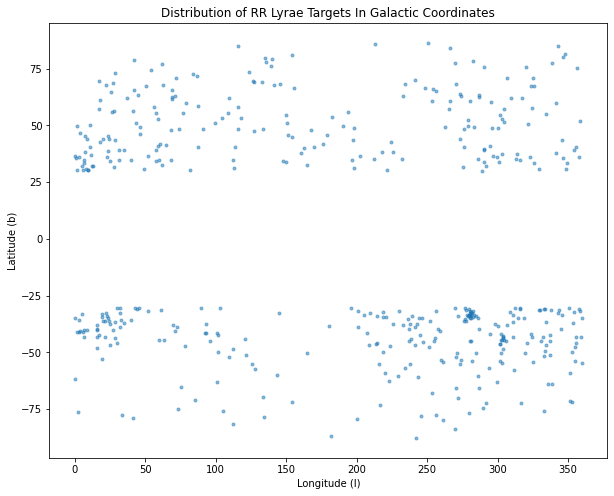

In [8]:
plt.figure(figsize = (10, 8), facecolor = 'w')
plt.title('Distribution of RR Lyrae Targets In Galactic Coordinates')
plt.scatter(results_dist['l'], results_dist['b'], marker = '.', alpha = 0.5)
plt.xlabel('Longitude (l)')
plt.ylabel('Latitude (b)')
plt.show()

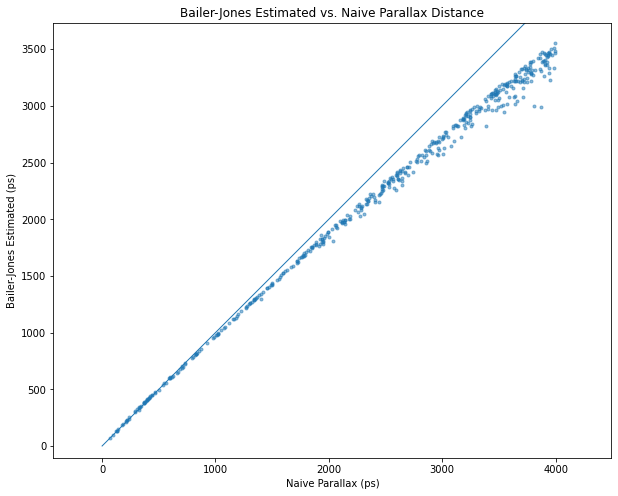

In [9]:
plt.figure(figsize = (10, 8), facecolor = 'w')
plt.title('Bailer-Jones Estimated vs. Naive Parallax Distance')
plt.scatter(1000 / results_dist['parallax'], results_dist['r_est'], marker = '.', alpha = 0.5)
plt.axis('equal')
plt.xlabel('Naive Parallax (ps)')
plt.ylabel('Bailer-Jones Estimated (ps)')
plt.gca().add_line(lines.Line2D((0, 9000), (0, 9000), linewidth = 1, linestyle = '-'))
plt.show()

Bailer-Jones closely follows the naive for closer stars, but as they get farther the estimate becomes less than the naive. There is probably more room for correction on the far-away stars which is why they have a bigger difference between the estimate.

## 15. Plot period vs. absolute G-band magnitude for all stars returned by your query

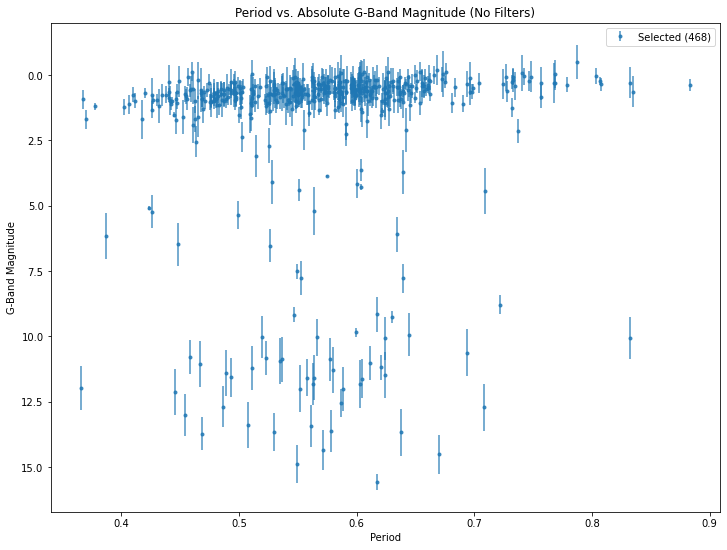

[[ 1.         -0.04465552]
 [-0.04465552  1.        ]]


In [10]:
def plot_period_v_gband(res, note, mask = None):
    if mask is None:
        mask = np.ones(len(res), dtype = bool)
    plt.figure(figsize = (12, 9), facecolor = 'w')
    plt.title('Period vs. Absolute G-Band Magnitude ({})'.format(note))
    
    rt = res[mask]
    plt.errorbar(rt['pf'], rt['mg'], yerr = rt['mg_error'],
            fmt = '.', alpha = 0.8, label = 'Selected ({})'.format(mask.sum()))

    rej = (~mask).sum()
    if rej > 0:
        rt = res[~mask]
        plt.errorbar(rt['pf'], rt['mg'], yerr = rt['mg_error'],
                fmt = '.', alpha = 0.8, label = 'Rejected ({})'.format(rej), c = 'g')
    
    plt.xlabel('Period')
    plt.ylabel('G-Band Magnitude')
    plt.legend()
    
    plt.ylim(plt.ylim()[::-1])
    plt.show()

plot_period_v_gband(results_dist, note = 'No Filters')
print(np.corrcoef(results_dist['int_average_g'], results_dist['pf']))

## 16. Lindegren et al. 2018 Cuts

### C1 Equation:
$$u < 1.2* max(1, exp(-0.2*(G - 19.5)))$$

### C2 Equation:
$$1.0 + 0.015 * (G_{BP} - G_{RP})^2 < E < 1.3 + 0.06 * (G_{BP} - G_{RP})^2$$

C1:   468 -> 464.
C2:   468 -> 409.
Both: 468 -> 409.


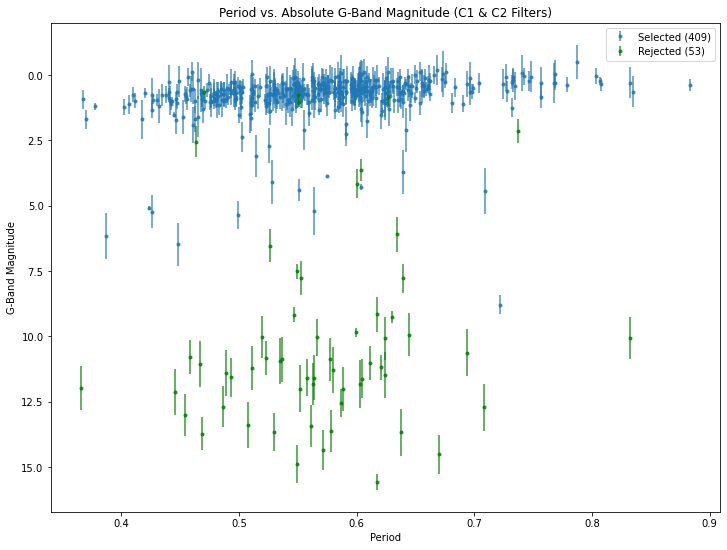

In [11]:
_u = np.sqrt(results_dist['astrometric_chi2_al'] / (results_dist['astrometric_n_good_obs_al'] - 5))
_rhs = 1.2 * np.clip(-0.2 * (results_dist['mg_error'] - 19.5), 1, None)
c1_mask = _u < _rhs
print('C1:   {} -> {}.'.format(len(results_dist), c1_mask.sum()))

_sqd = results_dist['bp_rp'] ** 2
_e = results_dist['phot_bp_rp_excess_factor']
c2_mask = (1.0 + 0.015 * _sqd < _e) & (_e < 1.3 + 0.06 * _sqd)
print('C2:   {} -> {}.'.format(len(results_dist), c2_mask.sum()))

print('Both: {} -> {}.'.format(len(results_dist), (c1_mask & c2_mask).sum()))

results_qc = results_dist[c1_mask & c2_mask]

plot_period_v_gband(results_dist, note = 'C1 & C2 Filters', mask = c1_mask & c2_mask)

The scatter plot has decreased in the number of points selected. In the plot above you can see the ones that are now still selected in blue and the ones that were in the original plot but are now cut in green.

It removed a lot of outlier points far away from the main cluster, so it is proably a good cut.

## 17. Crude Cuts & Error Bars

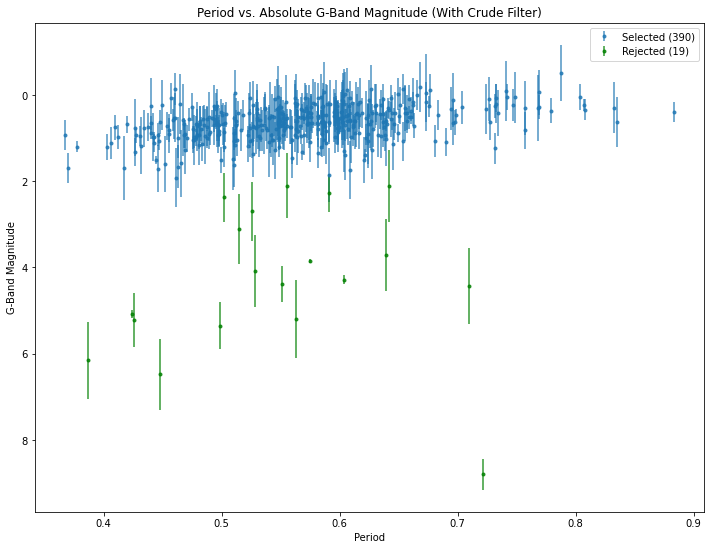

In [12]:
lt3_mask = results_qc['mg'] < 2
results_lt3 = results_qc[lt3_mask]
plot_period_v_gband(results_qc, note = 'With Crude Filter', mask = lt3_mask)

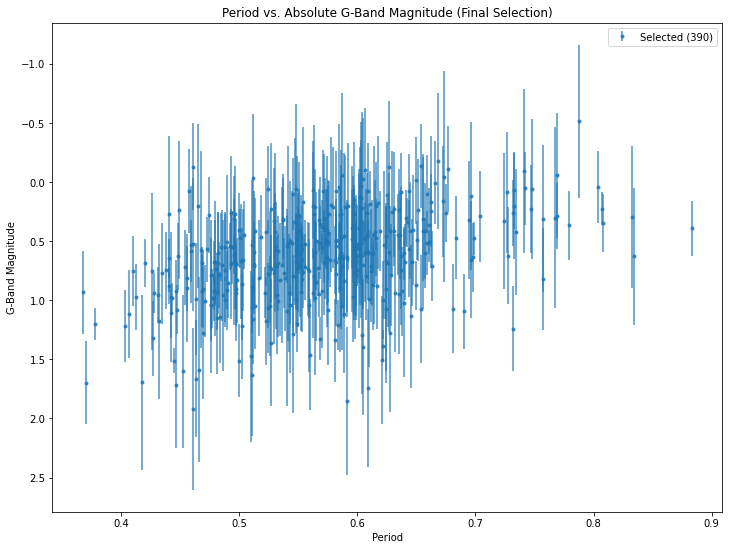

In [13]:
plot_period_v_gband(results_lt3, note = 'Final Selection')

## 18. MCMC

### 18(i) Metropolis-Hastings Test and Model

In [33]:
np.random.seed(4938902)

def metropolis_hastings(logp_fn, proposal_fn, prior_fn = None, steps = 4000, chains = 8):

    if None == prior_fn:
        prior_fn = lambda proposal: np.zeros(proposal.shape[0])
    
    init = proposal_fn(np.zeros(chains), True)
    assert 2 == len(init.shape)

    states = np.empty((chains, init.shape[1], 1 + steps))
    states[:, :, 0] = init

    logp_prev = logp_fn(init)
    
    num_acc = np.zeros(chains)

    for i in range(1, 1 + steps):
        print('{:.6}%     '.format(100 * i / steps), end = '\r')

        states[:, :, i] = states[:, :, i - 1]
        proposal = proposal_fn(states[:, :, i], False)
        logp_prop = logp_fn(proposal) + prior_fn(proposal)
        assert 1 == len(logp_prop.shape)
        
        alpha = logp_prev - logp_prop
        rng = np.random.exponential(size = chains)

        accepted = rng > alpha
        states[accepted, :, i] = proposal[accepted]
        logp_prev[accepted] = logp_prop[accepted]
        num_acc[accepted] += 1

    print()
    return states, num_acc / steps
        
def make_gaussian_proposal(sigma, size = 1):
    def prop(prev, init):
        if init:
            return np.zeros(prev.shape + (size, ))
        return np.random.normal(prev, sigma)
    return prop

def make_gaussian_logp(mu, sigma):
    def p(x):
        return stats.norm.logpdf(x[:, 0], loc = mu, scale = sigma)
    return p

100.0%     


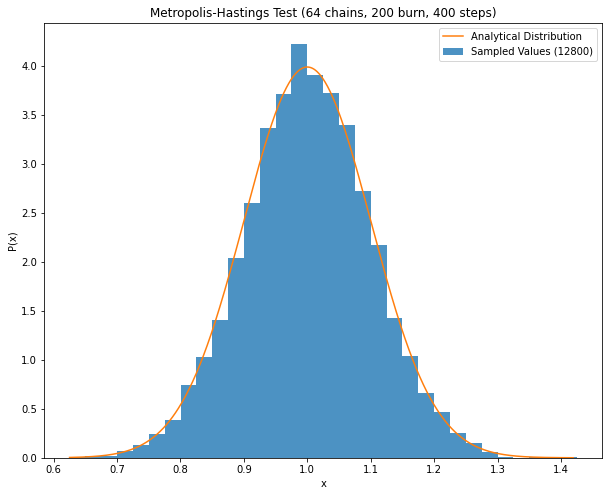

Accepted: 50.80078125000001%


In [34]:
prop = make_gaussian_proposal(0.2)
logp = make_gaussian_logp(1, 0.1)
chains = 64
burn = 200
steps = 400
all_states, all_acc_pct = metropolis_hastings(logp, prop, steps = steps, chains = chains)

states = all_states[:,:,burn+1:]
states = states.reshape(chains * states.shape[2], order = 'A')
acc_pct = all_acc_pct.mean()

binwidth = 0.025
x = np.linspace(states.min(), states.max(), 1000)
y = stats.norm.pdf(x, 1, 0.1)

plt.figure(figsize = (10, 8), facecolor = 'w')
plt.title('Metropolis-Hastings Test ({} chains, {} burn, {} steps)'.format(chains, burn, steps))
plt.hist(states, bins = np.arange(states.min(), states.max() + binwidth, binwidth),
         weights = np.ones(len(states)) / len(states) / binwidth,
         alpha = 0.8, label = 'Sampled Values ({})'.format(len(states)))
plt.plot(x, y, label = 'Analytical Distribution')
plt.legend()
plt.ylabel('P(x)')
plt.xlabel('x')
plt.show()

print('Accepted: {}%'.format(100 * acc_pct))

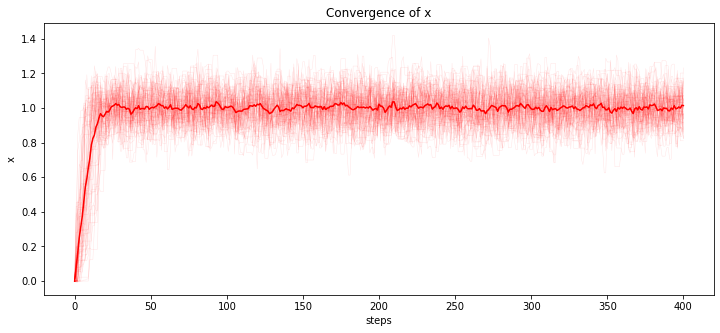

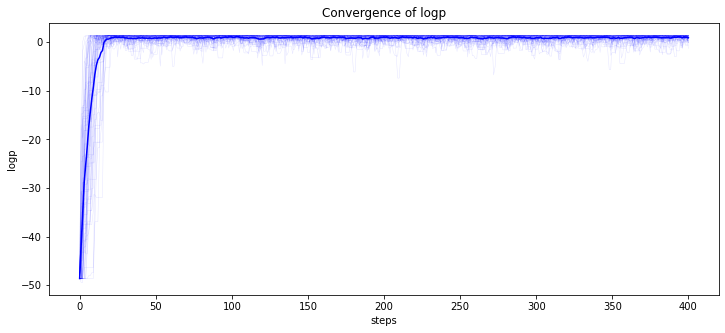

In [35]:
plt.figure(figsize = (12, 5), facecolor = 'w')
plt.title('Convergence of x')
plt.plot(all_states[:,0,:].T.mean(axis = 1), c = 'r')
plt.plot(all_states[:,0,:].T, c = 'r', linewidth = 0.5, alpha = 0.1)
plt.ylabel('x')
plt.xlabel('steps')
plt.show()

all_logps = logp(all_states).T
plt.figure(figsize = (12, 5), facecolor = 'w')
plt.title('Convergence of logp')
plt.plot(all_logps.mean(axis = 1), c = 'b')
plt.plot(all_logps, c = 'b', linewidth = 0.5, alpha = 0.1)
plt.ylabel('logp')
plt.xlabel('steps')
plt.show()

**Now the real thing.**

Model: $ M_G = a * \log(P) + b $ with scatter $\sigma_\text{scatter}$. (log base 10)

In [31]:
np.random.seed(123496799)

def predict(x, a, b):
    return a * np.log10(x) + b

def make_logp_given_abs(x_vals, y_vals, y_stdv):
    x_vals = np.array(x_vals)
    y_vals = np.array(y_vals)
    y_stdv = np.array(y_stdv)

    def logp_given_abs(absig):
        ab = absig[:, :2]
#         print(ab.shape)
        logsig = absig[:, 2]
#         print(np.log10(x_vals).shape)
#         print(np.row_stack([ np.log10(x_vals), np.ones(x_vals.shape) ]).shape)
        yhat = ab @ np.row_stack([ np.log10(x_vals), np.ones(x_vals.shape) ])
        resids = y_vals - yhat
#         print(np.add.outer(np.exp(logsig) ** 2, y_stdv ** 2).shape)
        print(np.exp(logsig).shape)
        sigmas_plus_y_errs = np.sqrt(np.add.outer(np.exp(logsig) ** 2, y_stdv ** 2))
        
        logpdfs = stats.norm.logpdf(resids, loc = 0, scale = sigmas_plus_y_errs)
        logsum = logpdfs.sum(axis = 1) 
        print(logsum.shape)
        return logsum

    return logp_given_abs

In [32]:
logp_given_abs = make_logp_given_abs(
        results_lt3['pf'], results_lt3['mg'],
        results_lt3['mg_error'])

prop = make_gaussian_proposal(0.05, size = 3)
logp = logp_given_abs
chains = 64
burn  = 0
steps = 5
all_states, all_acc_pct = metropolis_hastings(logp, prop, steps = steps + burn, chains = chains)
all_states = all_states[:,:,burn+1:]

(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)



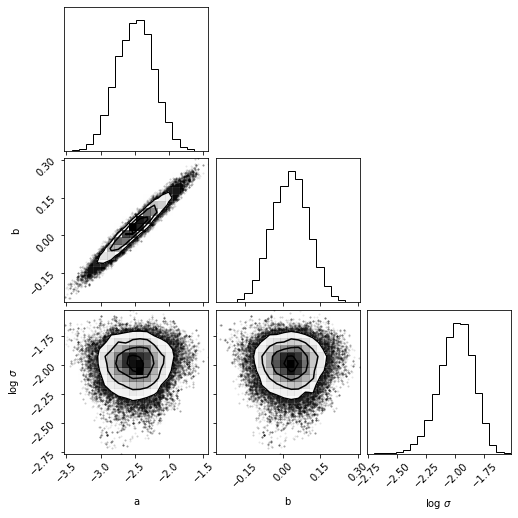

In [17]:
a_vals      = all_states[:, 0].reshape((-1,))
b_vals      = all_states[:, 1].reshape((-1,))
logsig_vals = all_states[:, 2].reshape((-1,))
s_vals      = np.exp(logsig_vals)

fig = corner.corner(np.column_stack([ a_vals, b_vals, logsig_vals ]),
        labels = [ 'a', 'b', '$\\log\\ \\sigma$' ], color = 'k')

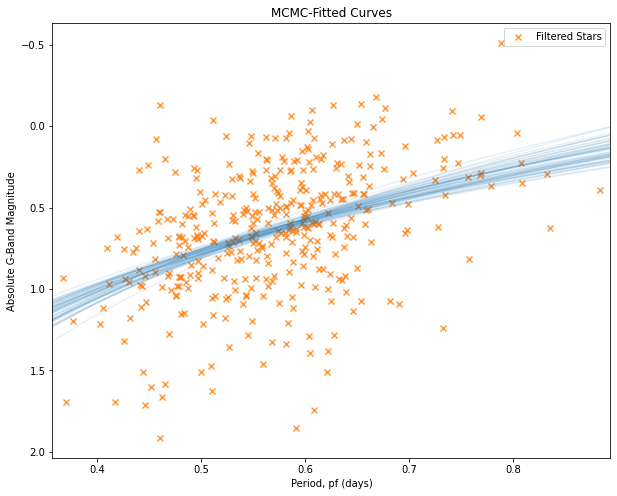

In [36]:
np.random.seed(9823092)

plt.figure(figsize = (10, 8), facecolor = 'w')
plt.title('MCMC-Fitted Curves')

x_vals = results_lt3['pf']
xlim = (x_vals.min() - 0.01, x_vals.max() + 0.01)
plt.xlim(*xlim)

xs = np.linspace(*xlim, 1000)
for i_rand in np.random.choice(len(a_vals), 50):
    a_hat = a_vals[i_rand]
    b_hat = b_vals[i_rand]
    ys = predict(xs, a_hat, b_hat)

    plt.plot(xs, ys, c = 'C0', alpha = 0.1)

plt.scatter(x_vals, results_lt3['mg'], c = 'C1', marker = 'x', alpha = 0.8, label = 'Filtered Stars')
plt.legend()

plt.xlabel('Period, pf (days)')
plt.ylabel('Absolute G-Band Magnitude')
plt.ylim(plt.ylim()[::-1])

plt.show()

### 18(ii)

In [38]:
x_vals = np.array(results_lt3['pf'])
y_vals = np.array(results_lt3['mg'])
y_stdv = np.array(results_lt3['mg_error'])

with pm.Model() as basic_model:
    
    var_names = [ 'a', 'b', 'logsig' ]

    # Priors for unknown model parameters
    a = pm.Normal('a', mu = 0, sigma = 10)
    b = pm.Normal('b', mu = 0, sigma = 10)
    logsig = pm.Normal('logsig', mu = 0, sigma = 5)

    # Expected value of outcome
    mu = a * np.log10(x_vals) + b
    
    # Residual error
    resid = y_vals - mu
    # Per-point standard deviation
    var_both = y_stdv ** 2 + pm.math.exp(2 * logsig)
    # Per-point log likelihood
    logps = -np.log(var_both) - resid ** 2 / var_both
    # Overall likelihood
    total_logp = logps.sum()
    
    # Potential
    potential = pm.Potential('logp', total_logp)
    
    # pm.sample will run the sampler and store output in 'trace' 
    trace_ii = pm.sample(draws = 4096, tune = 4096, chains = 2, cores = 1)

/home/rafferino/.local/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [logsig, b, a]


Sampling 2 chains for 4_096 tune and 4_096 draw iterations (8_192 + 8_192 draws total) took 26 seconds.


/Users/TiffanyE16/anaconda3/envs/astro/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/TiffanyE16/anaconda3/envs/astro/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/TiffanyE16/anaconda3/envs/astro/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/TiffanyE16/anaconda3/envs/astro/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-2.496,0.189,-2.847,-2.144,0.003,0.002,3044.0,3035.0,3049.0,3166.0,1.0
b,0.029,0.050,-0.063,0.122,0.001,0.001,3059.0,2325.0,3065.0,3316.0,1.0
logsig,-1.992,0.100,-2.184,-1.814,0.002,0.001,4023.0,3956.0,4143.0,3539.0,1.0


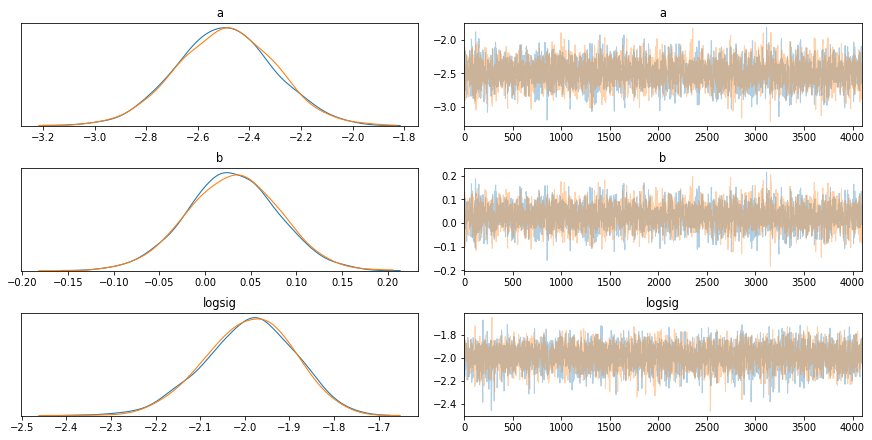

In [33]:
trace = trace_ii
# traceplot is a routine for plotting the 'traces' from the samples
pm.traceplot(trace, var_names = trace.varnames)

# pm.summary provides some useful summary and convergance statistics
display(pm.summary(trace, var_names = trace.varnames))

### 18(iii)

In [39]:
with pm.Model() as basic_model:
    var_names = [ 'a', 'b', 'logsig' ]

    # Priors for unknown model parameters
    a      = pm.Normal('a',      mu = 0, sigma = 10)
    b      = pm.Normal('b',      mu = 0, sigma = 10)
    logsig = pm.Normal('logsig', mu = 0, sigma = 5)

    # Expected value of outcome
    mu = a * np.log10(x_vals) + b

    # Likelihood (sampling distribution) of observations
    _y_obs = pm.Normal('y_obs', mu = mu, sigma = np.sqrt(y_stdv ** 2 + pm.math.exp(logsig) ** 2), observed = y_vals)

    # pm.sample will run the sampler and store output in 'trace' 
    trace_iii = pm.sample(draws = 4096, tune = 4096, chains = 2, cores = 1)

/home/rafferino/.local/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [logsig, b, a]


Sampling 2 chains for 4_096 tune and 4_096 draw iterations (8_192 + 8_192 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8837398191805579, but should be close to 0.8. Try to increase the number of tuning steps.


/home/rafferino/.local/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/rafferino/.local/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-2.504,0.270,-3.027,-2.024,0.005,0.004,2750.0,2750.0,2750.0,2959.0,1.0
b,0.027,0.071,-0.111,0.155,0.001,0.001,2705.0,2321.0,2699.0,3198.0,1.0
logsig,-2.001,0.157,-2.290,-1.708,0.003,0.002,3461.0,3354.0,3662.0,2585.0,1.0


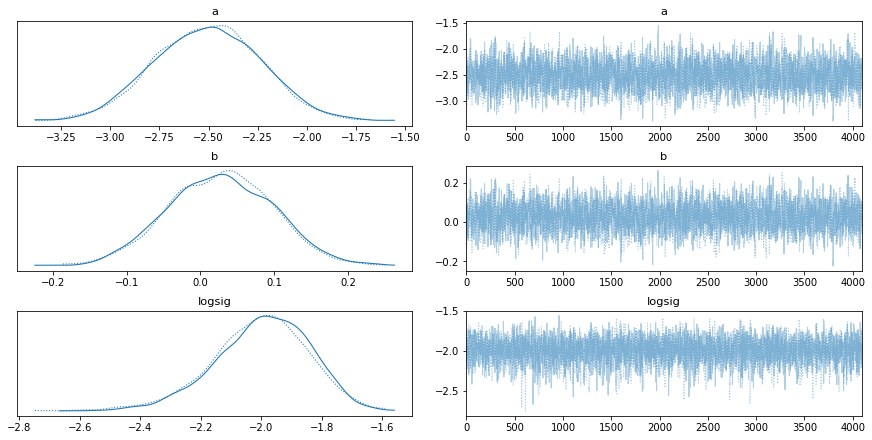

In [40]:
trace = trace_iii
# traceplot is a routine for plotting the 'traces' from the samples
pm.traceplot(trace, var_names = trace.varnames)

# pm.summary provides some useful summary and convergance statistics
display(pm.summary(trace, var_names = trace.varnames))

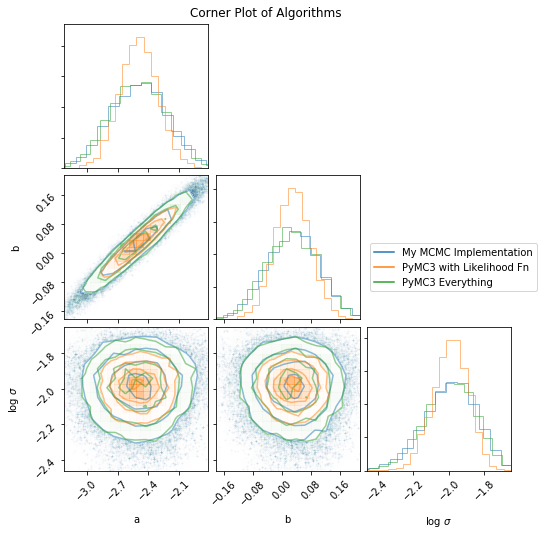

In [36]:
bins = 20
alpha_color = 0.5
alpha_speck = 0.02

fig = corner.corner(np.column_stack([ a_vals, b_vals, logsig_vals ]),
        bins = bins, color = colors.to_rgb('C0') + ( alpha_color, ),
        data_kwargs = { 'alpha': alpha_speck }, hist_kwargs = { 'density': True })
l0 = lines.Line2D([], [], color = 'C0', label = 'My MCMC Implementation')

fig = corner.corner(np.column_stack([ trace_iii['a'], trace_iii['b'], trace_iii['logsig'] ]),
        bins = bins, color = colors.to_rgb('C2') + ( alpha_color, ),
        data_kwargs = { 'alpha': alpha_speck }, hist_kwargs = { 'density': True },
        fig = fig)
l2 = lines.Line2D([], [], color = 'C2', label = 'PyMC3 Everything')

fig = corner.corner(np.column_stack([ trace_ii['a'], trace_ii['b'], trace_ii['logsig'] ]),
        bins = bins, color = colors.to_rgb('C1') + ( alpha_color, ),
        data_kwargs = { 'alpha': alpha_speck }, hist_kwargs = { 'density': True },
        labels = [ 'a', 'b', '$\\log\\ \\sigma$' ],
        fig = fig)
l1 = lines.Line2D([], [], color = 'C1', label = 'PyMC3 with Likelihood Fn')

fig.suptitle('Corner Plot of Algorithms')
fig.legend(handles = [ l0, l1, l2 ], loc = 'center right')
pass

## 19.

Updated query.

## 20.

In [37]:
x_vals = np.array(results_lt3['pf'])
y_vals = np.array(results_lt3['w2mpro_mg'])
y_stdv = np.array(results_lt3['w2mpro_error'])

with pm.Model() as basic_model:
    var_names = [ 'a', 'b', 'logsig' ]

    # Priors for unknown model parameters
    a      = pm.Normal('a',      mu = 0, sigma = 10)
    b      = pm.Normal('b',      mu = 0, sigma = 10)
    logsig = pm.Normal('logsig', mu = 0, sigma = 5)

    # Expected value of outcome
    mu = a * np.log10(x_vals) + b

    # Likelihood (sampling distribution) of observations
    _y_obs = pm.Normal('y_obs', mu = mu, sigma = np.sqrt(y_stdv ** 2 + pm.math.exp(logsig) ** 2), observed = y_vals)

    # pm.sample will run the sampler and store output in 'trace' 
    trace_w2 = pm.sample(draws = 4096, tune = 4096, chains = 2, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [logsig, b, a]
Sampling chain 1, 0 divergences: 100%|██████████| 8192/8192 [00:16<00:00, 498.12it/s]


/Users/TiffanyE16/anaconda3/envs/astro/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/TiffanyE16/anaconda3/envs/astro/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/TiffanyE16/anaconda3/envs/astro/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/TiffanyE16/anaconda3/envs/astro/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-3.325,0.262,-3.823,-2.859,0.005,0.003,3292.0,3266.0,3305.0,3259.0,1.0
b,-1.434,0.067,-1.561,-1.312,0.001,0.001,3283.0,3266.0,3298.0,3129.0,1.0
logsig,-1.115,0.037,-1.186,-1.049,0.001,0.000,3530.0,3530.0,3538.0,2914.0,1.0


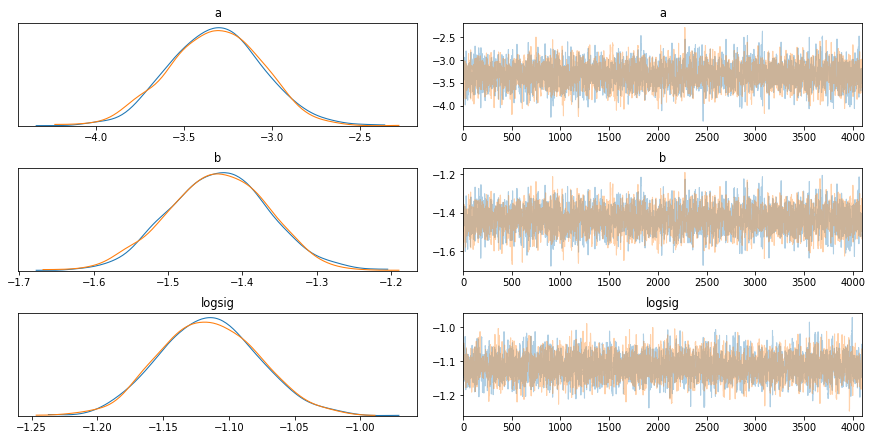

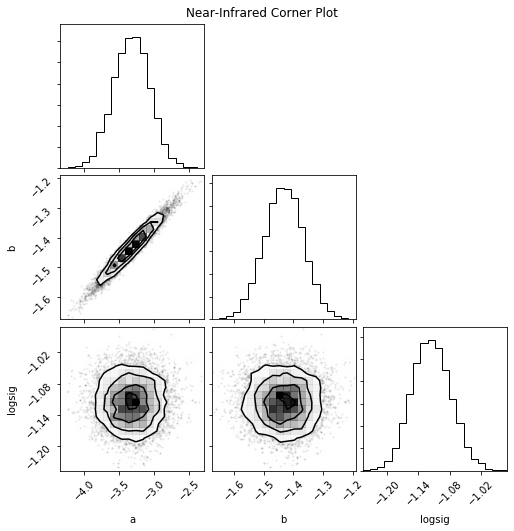

In [38]:
trace = trace_w2
# traceplot is a routine for plotting the 'traces' from the samples
pm.traceplot(trace, var_names = trace.varnames)

# pm.summary provides some useful summary and convergance statistics
display(pm.summary(trace, var_names = trace.varnames))

fig = corner.corner(np.column_stack([ trace[vn] for vn in trace.varnames ]),
    labels = trace.varnames, color = 'k')
fig.suptitle('Near-Infrared Corner Plot')
pass

## 21. Comparison W2 vs G-Band

The relationship is steeper for the W2 band at `a=-1.4`. G-band has `a=-1.1`.

The offset is larger for the W2 band at `b=-1.4`. G-band has `b=0`.

The scatter is about the same, slightly larger for W2.

## 22. Comparison vs Literature

Using Klein & Bloom models:
* `M_V  =  0.4319 - 0.4091 log10(P)`
* `M_W2 = -0.4583 - 2.2337 log10(P)`

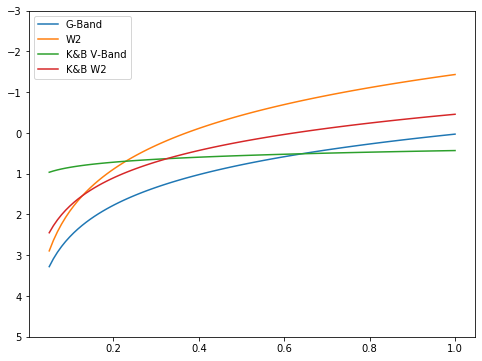

In [39]:
plt.figure(figsize = (8, 6), facecolor = 'w')
x_vals = np.linspace(0.05, 1.0, 100)

y_g     = predict(x_vals, trace_iii['a'].mean(), trace_iii['b'].mean())
y_w2    = predict(x_vals,  trace_w2['a'].mean(),  trace_w2['b'].mean())
y_kb_v  = predict(x_vals, -0.4091,  0.4319)
y_kb_w2 = predict(x_vals, -2.2337, -0.4583)

plt.plot(x_vals, y_g,     label = 'G-Band')
plt.plot(x_vals, y_w2,    label = 'W2')
plt.plot(x_vals, y_kb_v,  label = 'K&B V-Band')
plt.plot(x_vals, y_kb_w2, label = 'K&B W2')
plt.legend()
plt.ylim((5, -3))
plt.show()

The G band is similar to the V band, but they are not the same, so the lines are different. The W2 bands are the same but the lines also don't completely match (but are similar).

There are a lot of different reasons why they are different. The K&B paper didn't have GAIA when it was written so of course it uses different data. And it uses different cuts to select which stars to use. There are many different things like that that make differences. But overall the curves do look similar. You can see which one matches with which without the legend.

## 23.

In [40]:
x_vals = np.array(results_lt3['pf'])
y_vals = np.array(results_lt3['bp_rp'])
y_stdv = np.array(results_lt3['bp_rp_error'])

with pm.Model() as basic_model:
    var_names = [ 'a', 'b', 'logsig' ]

    # Priors for unknown model parameters
    a      = pm.Normal('a',      mu = 0, sigma = 100)
    b      = pm.Normal('b',      mu = 0, sigma = 100)
    logsig = pm.Normal('logsig', mu = 0, sigma = 500)

    # Expected value of outcome
    mu = a * pm.math.log(x_vals) + b

    # Likelihood (sampling distribution) of observations
    _y_obs = pm.Normal('y_obs', mu = mu, sigma = np.sqrt(y_stdv ** 2 + pm.math.exp(logsig) ** 2), observed = y_vals)

    # pm.sample will run the sampler and store output in 'trace' 
    trace_23 = pm.sample(draws = 4096, tune = 4096, chains = 2, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [logsig, b, a]
Sampling chain 1, 0 divergences: 100%|██████████| 8192/8192 [00:15<00:00, 516.47it/s]


/Users/TiffanyE16/anaconda3/envs/astro/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/TiffanyE16/anaconda3/envs/astro/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/TiffanyE16/anaconda3/envs/astro/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/TiffanyE16/anaconda3/envs/astro/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.079,0.029,0.021,0.132,0.001,0.0,3079.0,3079.0,3078.0,2787.0,1.0
b,0.699,0.017,0.669,0.733,0.000,0.0,3184.0,3183.0,3185.0,3056.0,1.0
logsig,-2.479,0.037,-2.550,-2.411,0.001,0.0,3655.0,3654.0,3638.0,3114.0,1.0


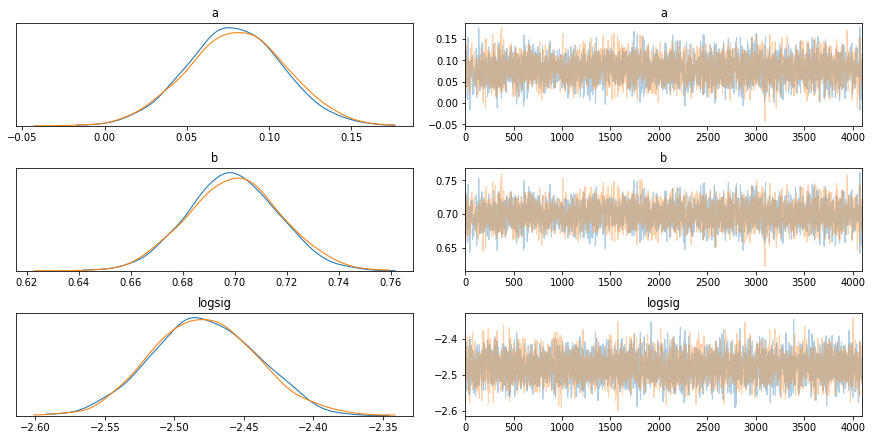

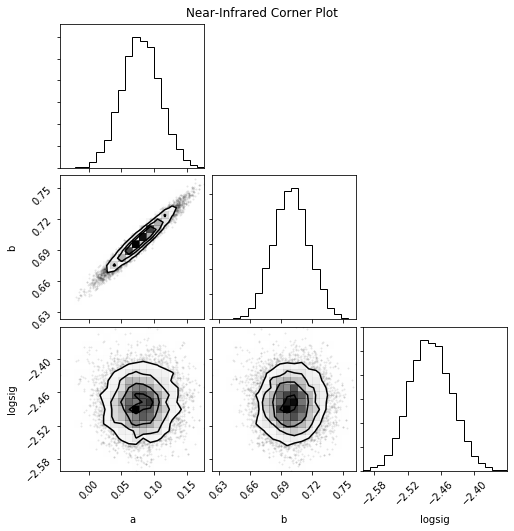

In [41]:
trace = trace_23
# traceplot is a routine for plotting the 'traces' from the samples
pm.traceplot(trace, var_names = trace.varnames)

# pm.summary provides some useful summary and convergance statistics
display(pm.summary(trace, var_names = trace.varnames))

fig = corner.corner(np.column_stack([ trace[vn] for vn in trace.varnames ]),
    labels = trace.varnames, color = 'k')
fig.suptitle('Near-Infrared Corner Plot')
pass

In [42]:
a_23 = trace_23['a'].mean()
b_23 = trace_23['b'].mean()
s_23 = np.exp(trace_23['logsig'].mean())

## 24.

In [43]:
query = '''\
SELECT
    gs.l, gs.b,
    gs.bp_rp,
    rr.pf, rr.g_absorption

    FROM gaiadr2.gaia_source AS gs
    INNER JOIN gaiadr2.vari_rrlyrae AS rr
    ON gs.source_id = rr.source_id
    WHERE
    rr.pf > 0
    AND gs.bp_rp IS NOT NULL
'''

job_all = gaia.launch_job_async(query)
results_all = job_all.get_results() 
print(len(results_all))

INFO: Query finished. [astroquery.utils.tap.core]
97895


## 25.

In [44]:
bp_rp_i = predict(np.array(results_all['pf']), a_23, b_23)
E_bp_rp = np.array(results_all['bp_rp']) - bp_rp_i
A_G = 2 * E_bp_rp

## 26.

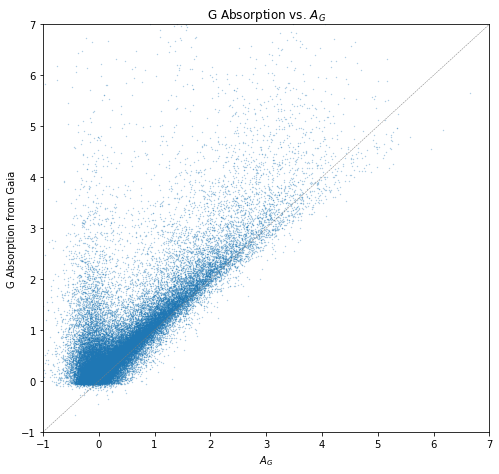

In [45]:
plt.figure(figsize = (8, 7.5), facecolor = 'w')
plt.title('G Absorption vs. $A_G$')
plt.scatter(A_G, results_all['g_absorption'], s = 0.1, alpha = 0.5)
plt.xlabel('$A_G$')
plt.ylabel('G Absorption from Gaia')

lim = ( -1, 7 )
plt.gca().add_line(lines.Line2D(lim, lim, c = 'gray', linewidth = 0.5, linestyle = '--'))
plt.xlim(lim)
plt.ylim(lim)
plt.show()

A lot of the stars correlate, but there are also a lot of stars that have $A_G$ around 0 regardless of their G absorption from Gaia. Using more filtering may help improve this, but overall the later parts still worked pretty well.

## 27.

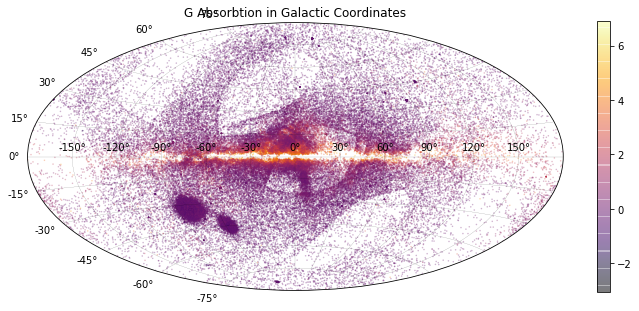

In [46]:
plt.figure(figsize = (12, 5), facecolor = 'w')

longitude = np.radians(np.mod(180 + np.array(results_all['l']), 360) - 180)
latitude = np.radians(np.array(results_all['b']))

# scatter
plt.subplot(1, 1, 1, projection = 'aitoff')
plt.scatter(longitude, latitude, c = A_G, cmap = 'inferno', s = 0.3, alpha = 0.3)
plt.grid(c = 'k', linewidth = 0.1)
plt.colorbar()
plt.title('G Absorbtion in Galactic Coordinates')

plt.show()

**You will notice that the distribution of RR Lyrae stars in the catalog is not at all uniform. Why is this?**

Gaia is rotating in space as it moves so the edges of the field of view might form some lines in the chart where there are more stars on one side and more on the other. And Gaia probably focuses on more interesting areas of sky than trying to find a uniform spread.

Also of course the stars themselves are not evenly distributed, most obviously in the plane of the galaxy. (Interesingly there are few LL Lyrae on the plane, probably because they are fainter stars and blocked out). And there are clusters of stars such as the giant ones in the bottom left and small ones in the top right.

## 28.

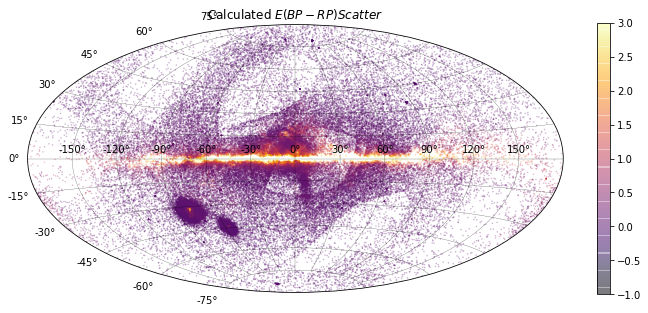

In [47]:
sfd = SFDQuery()

rr_coords = SkyCoord(longitude, latitude, unit = 'rad', frame = 'galactic')
sfd_data = sfd(rr_coords)

plt.figure(figsize = (12, 5), facecolor = 'w')

# scatter
plt.subplot(1, 1, 1, projection = 'aitoff')
plt.title('Calculated $E(BP-RP) Scatter$')
plt.scatter(longitude, latitude, c = sfd_data, cmap = 'inferno', s = 0.3, alpha = 0.3, vmin = -1, vmax = 3)
plt.grid(c = 'k', linewidth = 0.2)
plt.colorbar()
plt.show()

The SFD plot actually looks very similar to my plot (if we limit the range of the color map). It looks really good!

## 29.

**Do you expect your map to look exactly like the SFD?**

No, since there is a lot of differences between them. SFD uses a different dataset, different bands, and does a lot more filtering than I did. But I am still impressed that they look so similar.

A lot of the small details are matched, especially near the center of the plot. You can see some of the same shapes in higher-extinction areas. But there are also some details missing, like the high-extinction spot in the left cluster in the bottom-left quadrant.